In [6]:
import pandas as pd

In [9]:
df_train = pd.read_csv('../new_dataset/train/train_no_occluded.csv')
df_test = pd.read_csv('../new_dataset/test/test_no_occluded.csv')

train_base_path = '../new_dataset/train/rgb/train'
test_base_path = '../new_dataset/test/rgb'

In [4]:
def plot_sample(base_path, image_path, annotation):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import matplotlib.image as mpimg

    image = mpimg.imread(f"{base_path}/{image_path}")

    fig, ax = plt.subplots(2)
    ax[0].imshow(image)

    # Create a Rectangle patch
    rect = patches.Rectangle((annotation.x_min, annotation.y_min), 
                           annotation.x_max - annotation.x_min, 
                           annotation.y_max - annotation.y_min, 
                           linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax[0].add_patch(rect)
    
    # Convertendo para inteiros antes de fazer o slice
    y_min = int(annotation.y_min)
    y_max = int(annotation.y_max)
    x_min = int(annotation.x_min)
    x_max = int(annotation.x_max)
    
    # Usando os valores convertidos
    ax[1].imshow(image[y_min:y_max, x_min:x_max])
    ax[1].set_xlim(0, x_max - x_min)
    ax[1].set_ylim(0, y_max - y_min)
    ax[1].set_title("Zoomed In")
    ax[0].set_title("Original Image")
    plt.title(f"Label: {annotation.label}, Occluded: {annotation.occluded}")
    plt.tight_layout()
    plt.show()

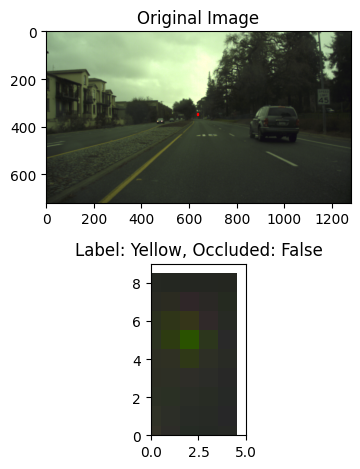

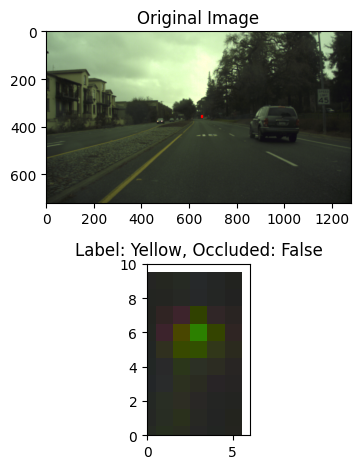

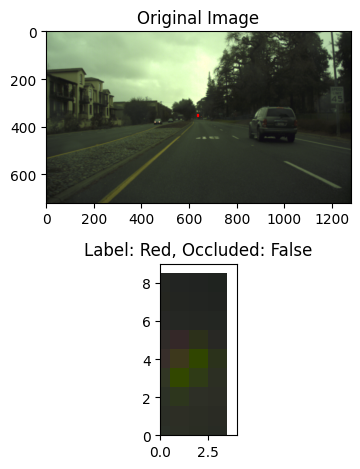

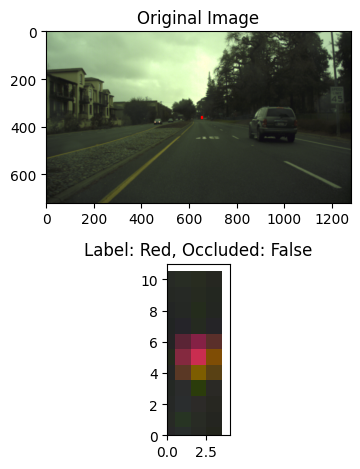

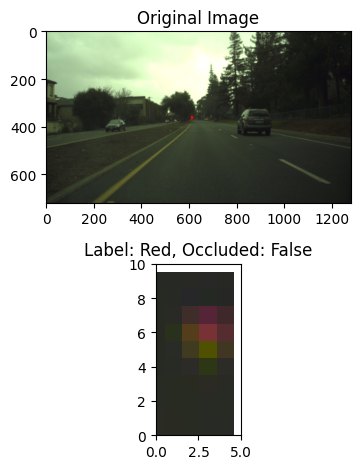

In [10]:
for i in range(5):
    # Plotando amostras do conjunto de treinamento
    plot_sample(train_base_path, df_train.iloc[i].image_path, df_train.iloc[i])

In [11]:
import cv2
import numpy as np

def preprocess_image(base_path, image_path, annotation, target_size=(64, 64)):
    """
    Recorta a região de interesse (ROI) e redimensiona para o tamanho alvo.
    
    Args:
        base_path: Caminho base das imagens
        image_path: Caminho relativo da imagem
        annotation: Linha do DataFrame com as anotações
        target_size: Tupla (altura, largura) para o tamanho final da imagem
    
    Returns:
        Imagem processada como array numpy
    """
    
    # Lê a imagem
    img = cv2.imread(f"{base_path}/{image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Converte coordenadas para inteiros
    x_min = int(annotation.x_min)
    y_min = int(annotation.y_min)
    x_max = int(annotation.x_max)
    y_max = int(annotation.y_max)
    
    # Recorta a região de interesse
    roi = img[y_min:y_max, x_min:x_max] 

    # Redimensiona para o tamanho alvo
    processed_img = cv2.resize(roi, target_size)
    
    # Normaliza os valores dos pixels para [0,1]
    processed_img = processed_img.astype(np.float32) / 255.0
    
    return processed_img

def resize_ratio_calc(base_path, image_path, annotation, target_size=(64, 64)):
    """
    Calcula a razão de redimensionamento para a imagem original.
    
    Args:
        base_path: Caminho base das imagens
        image_path: Caminho relativo da imagem
        annotation: Linha do DataFrame com as anotações
        target_size: Tupla (altura, largura) para o tamanho final da imagem
    
    Returns:
        Razão de redimensionamento como tupla (altura, largura)
    """
    # Lê a imagem
    img = cv2.imread(f"{base_path}/{image_path}")
    
    # Converte coordenadas para inteiros
    x_min = int(annotation.x_min)
    y_min = int(annotation.y_min)
    x_max = int(annotation.x_max)
    y_max = int(annotation.y_max)
    
    # Calcula a razão de redimensionamento
    height_ratio = target_size[0] / (y_max - y_min)
    width_ratio = target_size[1] / (x_max - x_min)
    
    return height_ratio, width_ratio


## Prepare dataset

In [33]:
def prepare_dataset(df, base_path, target_size=(64, 64)):
    """
    Prepara o conjunto de dados convertendo imagens em arrays numpy
    e criando rótulos one-hot encoded.
    
    Args:
        df: DataFrame com as informações das imagens
        base_path: Caminho base para as imagens
        target_size: Tamanho desejado para as imagens
    
    Returns:
        X: Array numpy com as imagens processadas
        y: Array numpy com os rótulos
    """
    from sklearn.preprocessing import LabelEncoder
    from tensorflow.keras.utils import to_categorical
    
    # Inicializa listas para armazenar dados
    X = []
    y = []
    
    # Processa cada imagem
    for idx, row in df.iterrows():
        # Processa a imagem
        try:
            img = preprocess_image(base_path, row.image_path, row, target_size)
            X.append(img)
            y.append(row.label)
        except Exception as e:
            print(f"Erro ao processar a imagem {row.image_path}: {e}")
            continue
    
    # Converte listas para arrays numpy
    X = np.array(X)
    
    # Codifica os rótulos
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y = to_categorical(y_encoded)
    
    return X, y, le.classes_

In [13]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def prepare_dataset_parallel(df, base_path, target_size=(64, 64), max_workers=8):
    """
    Prepara o conjunto de dados convertendo imagens em arrays numpy
    e criando rótulos one-hot encoded, com paralelização.
    
    Args:
        df: DataFrame com as informações das imagens
        base_path: Caminho base para as imagens
        target_size: Tamanho desejado para as imagens
        max_workers: Número de threads a usar
    
    Returns:
        X: Array numpy com as imagens processadas
        y: Array numpy com os rótulos
        classes: Lista com as classes originais
    """
    X = [None] * len(df)
    y = [None] * len(df)

    def process_row(i, row):
        return i, preprocess_image(base_path, row.image_path, row, target_size), row.label

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(process_row, i, row): i
            for i, row in df.iterrows()
        }
        for future in as_completed(futures):
            i = futures[future]
            try:
                idx, img, label = future.result()
                X[idx] = img
                y[idx] = label
            except Exception as e:
                print(f"Erro ao processar a imagem {df.iloc[i].image_path}: {e}")

    # Filtra pares válidos
    Xy_valid = [(img, label) for img, label in zip(X, y) if img is not None]

    # Separa novamente X e y
    X, y = zip(*Xy_valid) if Xy_valid else ([], [])

    X = np.array(X)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y = to_categorical(y_encoded)


    return X, y, le.classes_


In [ ]:
# Prepara os conjuntos de treino e teste
X_train, y_train, classes = prepare_dataset_parallel(df_train, train_base_path)
X_test, y_test, _ = prepare_dataset_parallel(df_test, test_base_path)

# Mostra informações sobre o conjunto de dados
print(f"Formato dos dados de treino: {X_train.shape}")
print(f"Formato dos rótulos de treino: {y_train.shape}")
print(f"Formato dos dados de teste: {X_test.shape}")
print(f"Formato dos rótulos de teste: {y_test.shape}")
print(f"\nClasses: {classes}")

# Visualiza algumas estatísticas básicas
print(f"\nValores únicos nos pixels: {len(np.unique(X_train))}")
print(f"Valor mínimo: {X_train.min()}")
print(f"Valor máximo: {X_train.max()}")
print(f"Média: {X_train.mean():.4f}")
print(f"Desvio padrão: {X_train.std():.4f}")

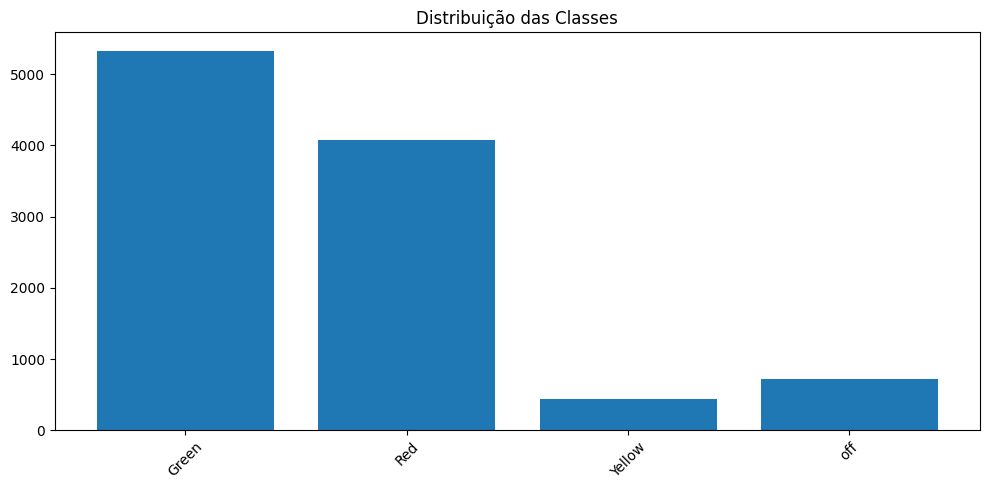

In [16]:
import matplotlib.pyplot as plt

# Visualiza a distribuição das classes
plt.figure(figsize=(10, 5))
plt.bar(classes, y_train.sum(axis=0))
plt.title("Distribuição das Classes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# save x_train and x_test as pickle
import pickle
save = False
if save:
    with open('../new_dataset/train/x_train.pkl', 'wb') as f:
        pickle.dump(X_train, f)
    with open('../new_dataset/train/y_train.pkl', 'wb') as f:
        pickle.dump(y_train, f)
    with open('../new_dataset/test/x_test.pkl', 'wb') as f:
        pickle.dump(X_test, f)
    with open('../new_dataset/test/y_test.pkl', 'wb') as f:
        pickle.dump(y_test, f)

if not save:
    with open('../new_dataset/train/x_train.pkl', 'rb') as f:
        X_train = pickle.load(f)
    with open('../new_dataset/train/y_train.pkl', 'rb') as f:
        y_train = pickle.load(f)
    with open('../new_dataset/test/x_test.pkl', 'rb') as f:
        X_test = pickle.load(f)
    with open('../new_dataset/test/y_test.pkl', 'rb') as f:
        y_test = pickle.load(f)

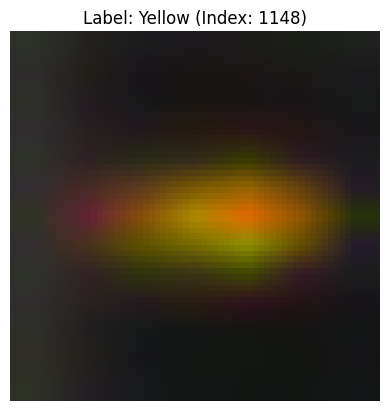

In [65]:
# plot a random image from x_train, transform it to PIL and show it
from PIL import Image
import random

def plot_image(X, y, classes, index=None):
    """
    Plota uma imagem aleatória do conjunto de dados.
    
    Args:
        X: Array numpy com as imagens
        y: Array numpy com os rótulos
        classes: Lista de classes
    """
    if index is None:
        idx = random.randint(0, len(X) - 1)
    else:
        idx = index
    img = Image.fromarray((X[idx] * 255).astype(np.uint8))
    plt.imshow(img)
    plt.title(f"Label: {classes[np.argmax(y[idx])]} (Index: {idx})")
    plt.axis('off')
    plt.show()
plot_image(X_train, y_train, classes)

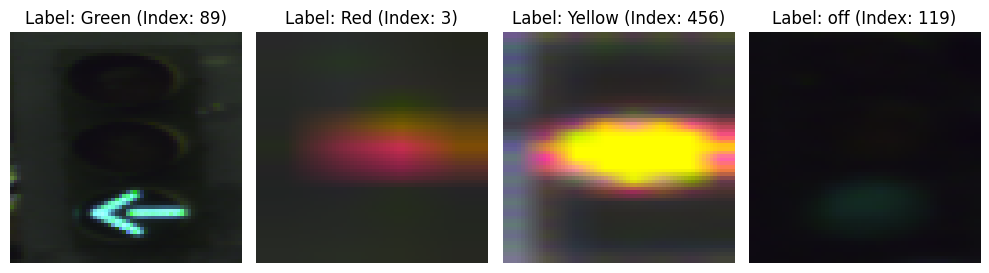

In [66]:
def classify(x):
    if x == 0:
        return 'Green'
    elif x == 1:
        return 'Red'
    elif x == 2:
        return 'Yellow'
    elif x == 3:
        return 'off'

indexes = [0, 0, 0, 0] # first index of each class

y_train_argmax = np.argmax(y_train, axis=1) # get the index of the class with the highest probability

excluded = [1, 2, 107, 108, 109, 110, 111, 114]

for i in range(len(y_train_argmax)): # stop when each index is different from 0
    if i in excluded:
        continue
    if y_train_argmax[i] == 0 and indexes[0] == 0:
        indexes[0] = i
    elif y_train_argmax[i] == 1 and indexes[1] == 0:
        indexes[1] = i
    elif y_train_argmax[i] == 2 and indexes[2] == 0:
        indexes[2] = i
    elif y_train_argmax[i] == 3 and indexes[3] == 0:
        indexes[3] = i

fig, ax = plt.subplots(1, 4, figsize=(10, 10))
for i in range(4):
    ax[i].imshow(X_train[indexes[i]])
    ax[i].set_title(f"Label: {classes[np.argmax(y_train[indexes[i]])]} (Index: {indexes[i]})")
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Model

In [67]:
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D, Cropping2D, Conv2DTranspose
from keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [69]:
input_shape = (64, 64, 3)

input_layer = Input(shape=input_shape)

# Encoder
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2), padding='same'),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.2),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax'),
])
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,772 (1.18 MB)

 Trainable params: 308,708 (1.18 MB)

 Non-trainable params: 64 (256.00 B)

In [70]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.8559 - loss: 0.3925 - val_accuracy: 0.9465 - val_loss: 0.7552
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.9269 - loss: 0.2065 - val_accuracy: 0.9507 - val_loss: 0.4246
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.9337 - loss: 0.1911 - val_accuracy: 0.9541 - val_loss: 0.1862
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.9413 - loss: 0.1749 - val_accuracy: 0.9654 - val_loss: 0.1356
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9421 - loss: 0.1662 - val_accuracy: 0.9555 - val_loss: 0.1208
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.9387 - loss: 0.1682 - val_accuracy: 0.9583 - val_loss: 0.1488
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 0.9432 - loss: 0.1607 - val_accuracy: 0.9678 - val_loss: 0.0993
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.9480 - loss: 0.

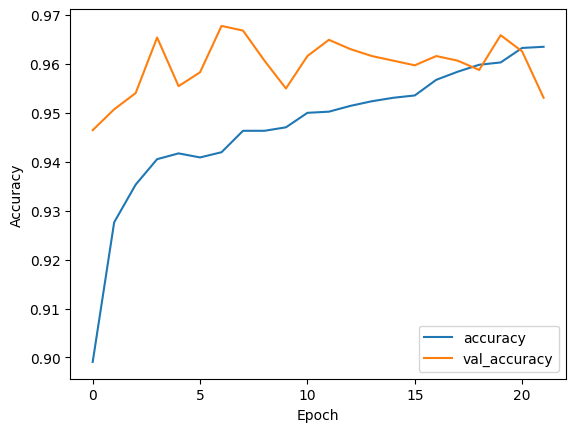

In [71]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step


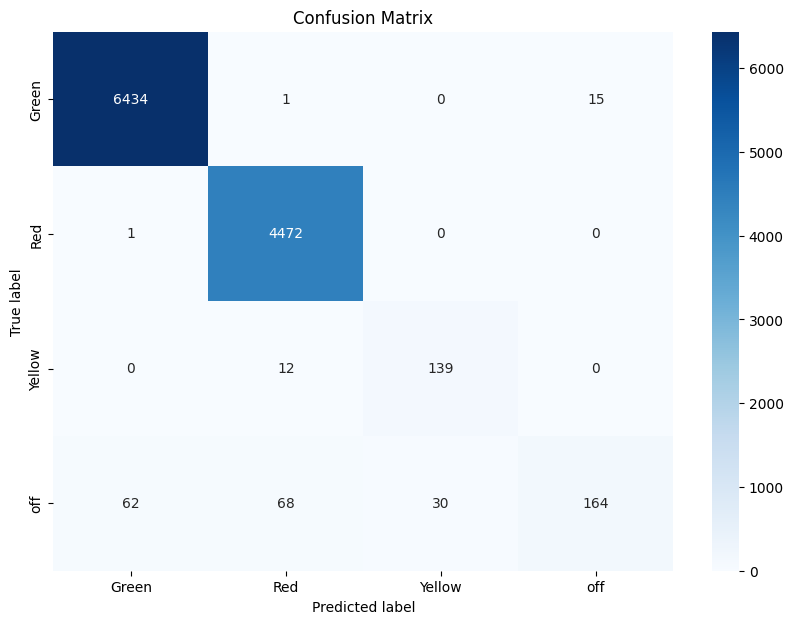

              precision    recall  f1-score   support

       Green       0.99      1.00      0.99      6450
         Red       0.98      1.00      0.99      4473
      Yellow       0.82      0.92      0.87       151
         off       0.92      0.51      0.65       324

    accuracy                           0.98     11398
   macro avg       0.93      0.86      0.88     11398
weighted avg       0.98      0.98      0.98     11398



In [72]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plota a matriz de confusão.
    
    Args:
        y_true: Rótulos verdadeiros
        y_pred: Rótulos previstos
        classes: Lista de classes
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Avalia o modelo no conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_classes, y_pred_classes, classes)

from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes, target_names=classes))

In [74]:
# save model checkpoint
from tensorflow.keras.models import load_model
model.save('../new_dataset/model.keras')